In [1]:
# For version check
from platform import python_version
from importlib.metadata import version

In [334]:
from functools import reduce, partial
from collections import defaultdict

from ete3 import Tree

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Search for gene ids 
## Human

In [73]:
! wget https://ftp.ncbi.nlm.nih.gov/gene/DATA/gene_info.gz -P ../data/08_GO_gene_subset/annotation/
! zcat ../data/08_GO_gene_subset/annotation/gene_info.gz | awk '$1 == 9606' > ../data/08_GO_gene_subset/ages_lists/human_genes_info.txt

In [260]:
human_gene_info = pd.read_csv('../data/08_GO_gene_subset/ages_lists/human_genes_info.txt', sep='\t',
                              header=None)
human_gene_info = human_gene_info[[1, 2, 4]]
human_gene_info.rename(columns = {1:'GeneID', 2: 'Symbol', 4: 'Synonyms'}, inplace = True)

In [261]:
# load GRM, add geneID to dataframe
human_GRN = pd.read_csv('../data/06_swiss_tree_blast/human_results/human_GRN_BLAST.csv')

# remove rows with unknown age
human_GRN.dropna(subset=['Tf_age', 'Tg_age'], inplace=True)
human_GRN.drop_duplicates(inplace=True)

genes_human = set(human_GRN.TF)
genes_human.update(human_GRN.Target)

In [262]:
# Add GeneIDs to gene names:
human_genes = pd.DataFrame({'Symbol': list(genes_human)})

human_genes['GeneID'] = human_genes.merge(human_gene_info, how='left', on=['Symbol']).GeneID

human_gene_info_synon = human_gene_info.loc[human_gene_info['Synonyms'] != '-']
human_gene_info_synon.loc[:,'Synonyms'] = human_gene_info_synon.loc[:,'Synonyms'].str.split('|')

/tmp/ipykernel_10338/136255577.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_gene_info_synon.loc[:,'Synonyms'] = human_gene_info_synon.loc[:,'Synonyms'].str.split('|')


In [263]:
na_genes = list(human_genes[human_genes['GeneID'].isna()].Symbol)
gene2id_dict = dict()

for index, row in human_gene_info_synon.iterrows():
    for gene in row['Synonyms']:
        if gene in na_genes:
            if gene not in gene2id_dict:
                gene2id_dict[gene] = row['GeneID']
            else:
                print(row['GeneID'], ':\t\t', gene)
                
for gene in gene2id_dict:
    human_genes.loc[human_genes['Symbol'] == gene, 'GeneID'] = gene2id_dict[gene]

In [264]:
# search for stil unknown gene id in https://david.ncifcrf.gov/conversion.jsp
# from list(human_gene_ages[human_gene_ages['GeneID'].isna()].Symbol)
# result in ../data/08_GO_gene_subset/ages_lists/conv_human.txt

# ! cat ../data/08_GO_gene_subset/ages_lists/conv_human.txt | awk '{print $1, $2}' > ../data/08_GO_gene_subset/ages_lists/conv_human_2col.txt

human_na_results = {}

with open('../data/08_GO_gene_subset/ages_lists/conv_human_2col.txt') as f:
    for line in f:
        (key, val) = line.split()
        human_na_results[key] = val

        
for gene in human_na_results:
    if gene == 'From':
        continue
    human_genes.loc[human_genes['Symbol'] == gene, 'GeneID'] = human_na_results[gene]

In [ ]:
human_genes.GeneID = human_genes.GeneID.astype(int)
#human_genes.to_csv('../data/08_GO_gene_subset/ages_lists/human_genes_id.csv', index=False)

In [266]:
human_genes = pd.read_csv('../data/08_GO_gene_subset/ages_lists/human_genes_id.csv')

In [268]:
human_genes

,Symbol,GeneID
0,NAB1,4664
1,EGLN2,112398
2,XIAP,331
3,ACRV1,56
4,TXNIP,10628
...,...,...
2827,POLR3D,3767
2828,CCR3,661
2829,GLS,1232
2830,SPRR2A,2744


In [325]:
# subset to try method
#human_subset = human_genes.sample(n=100)
#human_subset.Symbol.to_csv('../data/08_GO_gene_subset/ages_lists/human_subset_genes.list', header=None, index=None)

## Mouse

In [82]:
! zcat ../data/08_GO_gene_subset/annotation/gene_info.gz | awk '$1 == 10090' > ../data/08_GO_gene_subset/ages_lists/mouse_genes_info.txt

In [326]:
mouse_gene_info = pd.read_csv('../data/08_GO_gene_subset/ages_lists/mouse_genes_info.txt', sep='\t',
                              header=None)
mouse_gene_info = mouse_gene_info[[1, 2, 4]]
mouse_gene_info.rename(columns = {1:'GeneID', 2: 'Symbol', 4: 'Synonyms'}, inplace = True)

In [606]:
# load GRM, add geneID to dataframe
mouse_GRN = pd.read_csv('../data/06_swiss_tree_blast/mouse_results/mouse_GRN_BLAST.csv')

# remove rows with unknown age
mouse_GRN.dropna(subset=['Tf_age', 'Tg_age'], inplace=True) 
mouse_GRN.drop_duplicates(inplace=True)

genes_mouse = set(mouse_GRN.TF)
genes_mouse.update(mouse_GRN.Target)

In [328]:
# Add GeneIDs to gene names:
mouse_genes = pd.DataFrame({'Symbol': list(genes_mouse)})

mouse_genes['GeneID'] = mouse_genes.merge(mouse_gene_info, how='left', on=['Symbol']).GeneID

mouse_gene_info_synon = mouse_gene_info.loc[mouse_gene_info['Synonyms'] != '-']
mouse_gene_info_synon.loc[:,'Synonyms'] = mouse_gene_info_synon.loc[:,'Synonyms'].str.split('|')

/tmp/ipykernel_4679/3764015127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mouse_gene_info_synon.loc[:,'Synonyms'] = mouse_gene_info_synon.loc[:,'Synonyms'].str.split('|')


In [329]:
na_genes = list(mouse_genes[mouse_genes['GeneID'].isna()].Symbol)
gene2id_dict = dict()

for index, row in mouse_gene_info_synon.iterrows():
    for gene in row['Synonyms']:
        if gene in na_genes:
            if gene not in gene2id_dict:
                gene2id_dict[gene] = row['GeneID']
            else:
                print(row['GeneID'], ':\t\t', gene)
                
for gene in gene2id_dict:
    mouse_genes.loc[mouse_genes['Symbol'] == gene, 'GeneID'] = gene2id_dict[gene]

In [330]:
mouse_genes.GeneID = mouse_genes.GeneID.astype(int)
#mouse_genes.to_csv('../data/08_GO_gene_subset/ages_lists/mouse_genes_id.csv', index=False)

In [269]:
mouse_genes = pd.read_csv('../data/08_GO_gene_subset/ages_lists/mouse_genes_id.csv')

In [331]:
# subset to try method
#mouse_subset = mouse_genes.sample(n=100)
#mouse_subset.Symbol.to_csv('../data/08_GO_gene_subset/ages_lists/mouse_subset_genes.list', header=None, index=None)

# 1. GO tree search
## 1.1. Create GO-genes base

In [436]:
# Recursively find all the parent and child terms of the term

def transitive_closure(go_term, go):
    go_term_set = set()
    find_parents(go_term, go, go_term_set)
    find_children(go_term, go, go_term_set)
    return go_term_set
    
def find_parents(term1, go, go_term_set={}, ret=False):
    for term2 in term1.parents:
        go_term_set.update({term2})
        
        # Recurse on term to find all parents
        find_parents(term2, go, go_term_set) 
        
    if(ret):
        return go_term_set

def find_children(term1, go, go_term_set={}, ret=False):
    for term2 in term1.children:
        go_term_set.update({term2})
        
        # Recurse on term to find all children
        find_children(term2, go, go_term_set)
        
    if(ret):
        return go_term_set

In [565]:
# Load Associations
from __future__ import print_function
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.base import download_ncbi_associations

# Import the OBO parser from GOATools
from goatools import obo_parser

fin_gene2go = download_ncbi_associations()

    
# create a dictionary of the GO terms, 
# using the obo_parser from GOATools
#! wget http://current.geneontology.org/ontology/go-basic.obo -P ../data/08_GO_gene_subset/annotation/
    
go_base = obo_parser.GODag('../data/08_GO_gene_subset/annotation/go-basic.obo')

  EXISTS: gene2go
../data/08_GO_gene_subset/annotation/go-basic.obo: fmt(1.2) rel(2022-07-01) 47,008 Terms


### 1.1.1. Human

GOTools tutorial [link](https://nbviewer.org/urls/dessimozlab.github.io/go-handbook/GO%20Tutorial%20in%20Python%20-%20Solutions.ipynb).

- Level refers to the length of the shortest path from the top.
- Depth refers to the length of the longest path from the top.

In [571]:
# Read NCBI's gene2go. Store annotations in a list of namedtuples
objanno_human = Gene2GoReader(fin_gene2go, taxids=[9606])

# Get namespace2association where:
#    namespace is:
#        BP: biological_process               
#        MF: molecular_function
#        CC: cellular_component
#    assocation is a dict:
#        key: NCBI GeneID
#        value: A set of GO IDs associated with that gene

ns2assoc_human = objanno_human.get_ns2assc()

for nspc, id2gos in ns2assoc_human.items():
    print("{NS} {N:,} annotated human genes".format(NS=nspc, N=len(id2gos)))

HMS:0:00:03.332828 350,116 annotations, 20,727 genes, 18,978 GOs, 1 taxids READ: gene2go 
MF 18,265 annotated human genes
CC 19,760 annotated human genes
BP 18,707 annotated human genes


In [572]:
# Select only genes that exsist in GRN:
human_gene_list = human_genes.GeneID
BP_ns2assoc_human = dict((k, ns2assoc_human['BP'][k]) for k in human_gene_list if k in ns2assoc_human['BP'])

# Create dict GO - genes
# Dict structure GO_genes_dict (nested dictionary): {level: int, depth: int, genes: set()}

GO_genes_dict_human = dict()

for gene in BP_ns2assoc_human:
    for term in BP_ns2assoc_human[gene]:
        go_term = go_base[term]
        go_term_set = set([go_term])
        
        find_parents(go_term, go_base, go_term_set)
        
        for term_parents in go_term_set:
            
            if term_parents.id not in GO_genes_dict_human:
                # add {Level, Depth}
                GO_genes_dict_human[term_parents.id] = {'level': term_parents.level, 
                                                        'depth': term_parents.depth,
                                                        'genes': set()}
            # add genes
            GO_genes_dict_human[term_parents.id]['genes'].update({gene})

### 1.1.2 Mouse

In [573]:
# Read NCBI's gene2go. Store annotations in a list of namedtuples
objanno_mouse = Gene2GoReader(fin_gene2go, taxids=[10090])

# Get namespace2association where:
#    namespace is:
#        BP: biological_process               
#        MF: molecular_function
#        CC: cellular_component
#    assocation is a dict:
#        key: NCBI GeneID
#        value: A set of GO IDs associated with that gene

ns2assoc_mouse = objanno_mouse.get_ns2assc()

for nspc, id2gos in ns2assoc_mouse.items():
    print("{NS} {N:,} annotated mouse genes".format(NS=nspc, N=len(id2gos)))

HMS:0:00:05.732936 434,879 annotations, 29,857 genes, 19,025 GOs, 1 taxids READ: gene2go 
MF 17,526 annotated mouse genes
CC 19,486 annotated mouse genes
BP 18,879 annotated mouse genes


In [574]:
# Select only genes that exsist in GRN:
mouse_gene_list = mouse_genes.GeneID
BP_ns2assoc_mouse = dict((k, ns2assoc_mouse['BP'][k]) for k in mouse_gene_list if k in ns2assoc_mouse['BP'])

# Create dict GO - genes
# Dict structure GO_genes_dict (nested dictionary): {level: int, depth: int, genes: set()}

GO_genes_dict_mouse = dict()

for gene in BP_ns2assoc_mouse:
    for term in BP_ns2assoc_mouse[gene]:
        go_term = go_base[term]
        go_term_set = set([go_term])
        
        find_parents(go_term, go_base, go_term_set)
        
        for term_parents in go_term_set:
            
            if term_parents.id not in GO_genes_dict_mouse:
                # add {Level, Depth}
                GO_genes_dict_mouse[term_parents.id] = {'level': term_parents.level, 
                                                        'depth': term_parents.depth,
                                                        'genes': set()}
            # add genes
            GO_genes_dict_mouse[term_parents.id]['genes'].update({gene})

## 1.2. Calculate metric for GO terms

In [240]:
def select_subnet(gene_set, full_network, mode='both'):
    # Return subGRN from full FRN using genes set
    # mode: 'both', 'tf', 'target'
    if mode == 'both':
        return full_network[(full_network['TF_ID'].isin(gene_set)) & (full_network['Target_ID'].isin(gene_set))]
    if mode == 'tf':
        return full_network[full_network['TF_ID'].isin(gene_set)]
    if mode == 'target':
        return full_network[full_network['Target_ID'].isin(gene_set)]
    
    
def distance_calculation(network, max_distance):
    # Create pandas.core.series.Series with % distances relation
    # max_distance - number of possible distances in full GRN    
    if network.shape[0] != 0:
        empty_res = pd.Series([0] * 7)
        counts = pd.Series(network['age_length'].value_counts(normalize=True) * 100)
        adder = partial(pd.Series.add, fill_value=0)
        result = reduce(adder, [empty_res, counts])
        return result
    
    else:
        return None

### 1.2.1. Human

In [273]:
# Load full GRN
human_GRN = pd.read_csv('../data/06_swiss_tree_blast/human_results/human_GRN_BLAST.csv')
human_GRN.dropna(subset=['Tf_age', 'Tg_age'], inplace=True) 
human_GRN.drop_duplicates(inplace=True)

# Ages into integers
classes = ['no info', 'cellular organisms', 'Eukaryota', 'Opisthokonta',  'Eumetazoa', 
           'Vertebrata', 'Mammalia', 'Primates']

human_GRN['Tg_age_int'] = human_GRN['Tg_age'].apply(lambda x: classes.index(x))
human_GRN['TF_age_int'] = human_GRN['Tf_age'].apply(lambda x: classes.index(x))


human_GRN['age_length'] = np.where((human_GRN['TF_age_int'] == 0) | (human_GRN['Tg_age_int'] == 0),
                                    -1,
                                    abs(human_GRN['TF_age_int'] - human_GRN['Tg_age_int']))

# check 'no info' values
human_GRN[human_GRN.age_length == -1]

,TF,Target,Mode,PMID,Tf_age,Tg_age,Tg_age_int,TF_age_int,age_length


In [274]:
#Add GeneID to GRN
human_genes.rename(columns = {'Symbol':'TF'}, inplace=True)

human_GRN = human_GRN.merge(human_genes, how='left')

human_GRN.rename(columns = {'GeneID':'TF_ID'}, inplace=True)
human_genes.rename(columns = {'TF':'Target'}, inplace=True)

human_GRN = human_GRN.merge(human_genes, how='left')

human_genes.rename(columns = {'Target':'Symbol'}, inplace=True)
human_GRN.rename(columns = {'GeneID':'Target_ID'}, inplace=True)

human_GRN.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9326 entries, 0 to 9325
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   TF          9326 non-null   object
 1   Target      9326 non-null   object
 2   Mode        9326 non-null   object
 3   PMID        9326 non-null   object
 4   Tf_age      9326 non-null   object
 5   Tg_age      9326 non-null   object
 6   Tg_age_int  9326 non-null   int64 
 7   TF_age_int  9326 non-null   int64 
 8   age_length  9326 non-null   int64 
 9   TF_ID       9326 non-null   int64 
 10  Target_ID   9326 non-null   int64 
dtypes: int64(5), object(6)
memory usage: 874.3+ KB


In [277]:
# human_GRN.to_csv('../data/08_GO_gene_subset/ages_lists/human_GRN_iddistances.csv', index=False)

In [579]:
# Create dataframe with distance metric
# select small GRN for GO term - сontains only GO terms with more than 10 genes.

human_result_df = pd.DataFrame(columns = ["GO_term", "Level", "Depth",
                                          "Genes_number", "Edges_number",
                                          0, 1, 2, 3, 4, 5, 6])
#human_result_df[human_result_df.columns[1:5]] = human_result_df.iloc[:, 1:5].astype('int')
#human_result_df[human_result_df.columns[5:]] = human_result_df.iloc[:, 5:].astype('float')

for term in GO_genes_dict_human:
    if len(GO_genes_dict_human[term]['genes']) > 10:
        temp_GRN = select_subnet(GO_genes_dict_human[term]['genes'], human_GRN)
        max_distance = human_GRN.age_length.max()
        distance_series = distance_calculation(temp_GRN, max_distance)
        
        if distance_series is not None:
            temp_row = [term, 
                        GO_genes_dict_human[term]['level'], 
                        GO_genes_dict_human[term]['depth'],
                        len(GO_genes_dict_human[term]['genes']), 
                        temp_GRN.shape[0]]
            temp_row.extend(distance_series.tolist())
            human_result_df.loc[term] = temp_row
            
human_result_df

,GO_term,Level,Depth,Genes_number,Edges_number,0,1,2,3,4,5,6
GO:0001958,GO:0001958,4,4,16,1,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000
GO:0008150,GO:0008150,0,0,2801,9225,20.975610,27.013550,28.043360,16.921409,5.875339,1.084011,0.086721
GO:0032501,GO:0032501,1,1,958,2242,23.193577,26.895629,29.527208,15.254237,4.415700,0.713649,0.000000
GO:0036075,GO:0036075,3,3,16,1,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000
GO:0001503,GO:0001503,2,2,52,21,28.571429,28.571429,38.095238,4.761905,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
GO:0007266,GO:0007266,6,8,12,1,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
GO:1905898,GO:1905898,5,7,14,1,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000
GO:0008631,GO:0008631,5,7,11,1,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
GO:0001836,GO:0001836,7,7,12,11,54.545455,36.363636,0.000000,9.090909,0.000000,0.000000,0.000000


### 1.2.2. Mouse

In [278]:
# Load full GRN
mouse_GRN = pd.read_csv('../data/06_swiss_tree_blast/mouse_results/mouse_GRN_BLAST.csv')
mouse_GRN.dropna(subset=['Tf_age', 'Tg_age'], inplace=True) 
mouse_GRN.drop_duplicates(inplace=True)

# Ages into integers
classes = ['no info', 'cellular organisms', 'Eukaryota', 'Opisthokonta',  'Eumetazoa',
           'Vertebrata', 'Amniota', 'Rodentia']

mouse_GRN['Tg_age_int'] = mouse_GRN['Tg_age'].apply(lambda x: classes.index(x))
mouse_GRN['TF_age_int'] = mouse_GRN['Tf_age'].apply(lambda x: classes.index(x))


mouse_GRN['age_length'] = np.where((mouse_GRN['TF_age_int'] == 0) | (mouse_GRN['Tg_age_int'] == 0),
                                    -1,
                                    abs(mouse_GRN['TF_age_int'] - mouse_GRN['Tg_age_int']))

print(f'max lenght: {mouse_GRN["age_length"].max()}')

# check 'no info' values
mouse_GRN[mouse_GRN.age_length == -1]

max lenght: 6


,TF,Target,Mode,PMID,Tf_age,Tg_age,Tg_age_int,TF_age_int,age_length


In [279]:
#Add GeneID to GRN
mouse_genes.rename(columns = {'Symbol':'TF'}, inplace=True)

mouse_GRN = mouse_GRN.merge(mouse_genes, how='left')

mouse_GRN.rename(columns = {'GeneID':'TF_ID'}, inplace=True)
mouse_genes.rename(columns = {'TF':'Target'}, inplace=True)

mouse_GRN = mouse_GRN.merge(mouse_genes, how='left')

mouse_genes.rename(columns = {'Target':'Symbol'}, inplace=True)
mouse_GRN.rename(columns = {'GeneID':'Target_ID'}, inplace=True)

mouse_GRN.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6931 entries, 0 to 6930
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   TF          6931 non-null   object
 1   Target      6931 non-null   object
 2   Mode        6931 non-null   object
 3   PMID        6931 non-null   object
 4   Tf_age      6931 non-null   object
 5   Tg_age      6931 non-null   object
 6   Tg_age_int  6931 non-null   int64 
 7   TF_age_int  6931 non-null   int64 
 8   age_length  6931 non-null   int64 
 9   TF_ID       6931 non-null   int64 
 10  Target_ID   6931 non-null   int64 
dtypes: int64(5), object(6)
memory usage: 649.8+ KB


In [282]:
#mouse_GRN.to_csv('../data/08_GO_gene_subset/ages_lists/mouse_GRN_iddistances.csv', index=False)

In [585]:
# Create dataframe with distance metric
# select small GRN for GO term - сontains only GO terms with more than 10 genes.

mouse_result_df = pd.DataFrame(columns = ["GO_term", "Level", "Depth",
                                          "Genes_number", "Edges_number",
                                          0, 1, 2, 3, 4, 5, 6])
max_distance = mouse_GRN.age_length.max()

for term in GO_genes_dict_mouse:
    if len(GO_genes_dict_mouse[term]['genes']) > 10:
        temp_GRN = select_subnet(GO_genes_dict_mouse[term]['genes'], mouse_GRN)
        distance_series = distance_calculation(temp_GRN, max_distance)
        
        if distance_series is not None:
            temp_row = [term, 
                        GO_genes_dict_mouse[term]['level'], 
                        GO_genes_dict_mouse[term]['depth'],
                        len(GO_genes_dict_mouse[term]['genes']), 
                        temp_GRN.shape[0]]
            temp_row.extend(distance_series.tolist())
            
            mouse_result_df.loc[term] = temp_row

In [586]:
mouse_result_df

,GO_term,Level,Depth,Genes_number,Edges_number,0,1,2,3,4,5,6
GO:0050789,GO:0050789,2,2,2116,6343,22.891376,24.578275,30.915970,12.817279,7.740817,1.040517,0.015765
GO:0008150,GO:0008150,0,0,2378,6885,22.047930,24.458969,30.704430,13.783588,7.697894,1.278141,0.029049
GO:0007165,GO:0007165,2,4,938,2164,23.151571,23.243993,28.789279,14.279113,9.611830,0.924214,0.000000
GO:0007166,GO:0007166,3,5,589,1073,23.858341,25.163094,27.772600,14.725070,7.828518,0.652377,0.000000
GO:0065007,GO:0065007,1,1,2163,6439,22.751980,24.584563,30.889890,13.014443,7.671999,1.071595,0.015530
...,...,...,...,...,...,...,...,...,...,...,...,...
GO:0014742,GO:0014742,5,7,18,3,33.333333,33.333333,33.333333,0.000000,0.000000,0.000000,0.000000
GO:0010613,GO:0010613,6,8,18,3,33.333333,33.333333,33.333333,0.000000,0.000000,0.000000,0.000000
GO:0043666,GO:0043666,6,9,13,1,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000
GO:1901797,GO:1901797,7,8,14,1,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## 1.3.  Plot results
### 1.3.1. Human

In [533]:
human_result_df.drop(['Depth'], axis=1).groupby('Level').mean()

,Genes_number,Edges_number,0,1,2,3,4,5,6
Level,,,,,,,,,
0,2801.000000,9225.000000,20.975610,27.013550,28.043360,16.921409,5.875339,1.084011,0.086721
1,751.555556,1928.944444,19.832483,25.633150,29.689068,18.052240,4.106010,2.664676,0.022372
2,295.871287,519.702970,30.304904,25.370963,21.485228,15.729740,5.818178,1.280369,0.010620
3,176.187279,276.848057,29.805885,26.098560,22.637036,15.364658,5.011342,1.075152,0.007366
4,127.610000,192.114000,32.201405,24.670090,21.804994,15.481942,4.972192,0.857460,0.011917
5,90.048253,123.650582,29.924764,23.125841,22.085333,16.688353,6.575718,1.599130,0.000860
6,68.023904,79.868526,33.061544,22.554040,20.602240,15.864070,6.699614,1.217624,0.000867
7,63.988462,76.261538,36.868972,20.968049,18.599836,15.822336,6.219926,1.519127,0.001754
8,62.094340,78.660377,38.171793,20.390915,17.699460,15.042976,7.880237,0.813719,0.000900


<Figure size 432x288 with 0 Axes>

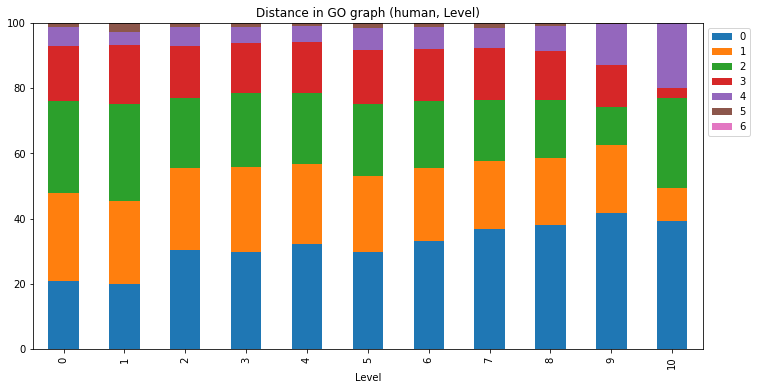

In [593]:
fig = plt.figure()

ax = human_result_df.drop(['Depth', 'Genes_number', 'Edges_number'], axis=1
                    ).groupby('Level', as_index=False).mean().plot.bar(
    x='Level', 
    stacked=True, 
    title='Distance in GO graph (human, Level)',
    figsize=(12,6))

ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_ylim(0, 100)

ax.figure.savefig('../data/08_GO_gene_subset/plots/human_level.png')

In [534]:
human_result_df.drop(['Level'], axis=1).groupby('Depth').mean()

,Genes_number,Edges_number,0,1,2,3,4,5,6
Depth,,,,,,,,,
0,2801.000000,9225.000000,20.975610,27.013550,28.043360,16.921409,5.875339,1.084011,0.086721
1,751.555556,1928.944444,19.832483,25.633150,29.689068,18.052240,4.106010,2.664676,0.022372
2,350.210526,639.578947,30.774598,23.890448,22.206921,15.760321,6.479329,0.875181,0.013201
3,212.765306,366.581633,29.935384,26.259741,22.396746,15.657601,4.893290,0.848890,0.008348
4,162.495652,267.649275,31.800572,24.873012,22.523207,15.141669,4.687707,0.955060,0.018772
5,115.580336,172.100719,30.818074,22.928167,22.594601,16.990667,5.640295,1.027022,0.001174
6,77.218962,83.514673,32.181731,22.514436,23.244587,15.124983,5.801586,1.131853,0.000824
7,55.553846,43.082051,30.601993,23.536256,19.564188,17.594859,6.994844,1.706891,0.000970
8,47.472924,39.902527,36.098577,22.702986,17.274624,15.468612,6.833681,1.621265,0.000253


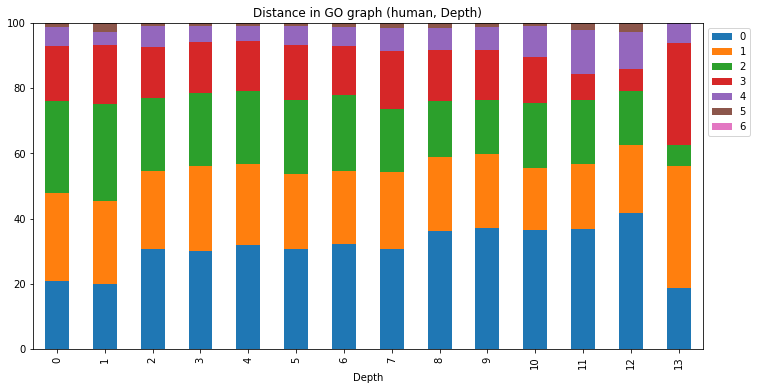

In [594]:
ax = human_result_df.drop(['Level', 'Genes_number', 'Edges_number'], axis=1
                    ).groupby('Depth', as_index=False).mean().plot.bar(
    x='Depth', 
    stacked=True, 
    title='Distance in GO graph (human, Depth)',
    figsize=(12,6))

ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_ylim(0, 100)

ax.figure.savefig('../data/08_GO_gene_subset/plots/human_depth.png')

### 1.3.2. Mouse

In [587]:
mouse_result_df.drop(['Depth'], axis=1).groupby('Level').mean()

,Genes_number,Edges_number,0,1,2,3,4,5,6
Level,,,,,,,,,
0,2378.000000,6885.000000,22.047930,24.458969,30.704430,13.783588,7.697894,1.278141,0.029049
1,652.611111,1664.444444,20.947714,18.537342,30.271212,20.639433,8.690210,0.897840,0.016250
2,247.409524,450.933333,29.496335,21.536420,26.556276,14.536287,6.956878,0.834612,0.083192
3,143.381579,233.253289,27.750499,23.083226,28.211566,12.775984,7.006552,1.147349,0.024823
4,111.517308,170.496154,28.600686,22.287952,28.976271,12.510598,6.589038,1.026644,0.008811
5,82.290064,115.118590,29.201269,20.732283,28.094657,12.058824,8.119504,1.712649,0.080814
6,62.909266,77.909266,29.811399,21.981521,27.779651,11.274691,7.528187,1.623690,0.000861
7,61.478599,80.291829,31.158188,20.644133,24.555491,12.947600,8.881251,1.812274,0.001063
8,58.954955,81.351351,36.277687,19.005316,25.234689,9.860933,9.137794,0.481878,0.001703


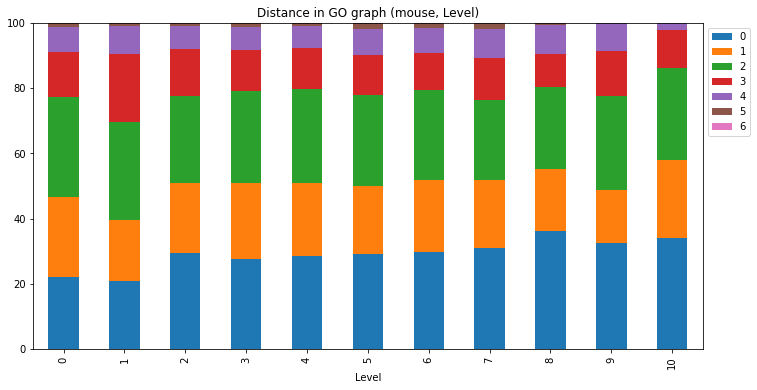

In [595]:
ax = mouse_result_df.drop(['Depth', 'Genes_number', 'Edges_number'], axis=1
                    ).groupby('Level', as_index=False).mean().plot.bar(
    x='Level', 
    stacked=True, 
    title='Distance in GO graph (mouse, Level)',
    figsize=(12,6))

ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_ylim(0, 100)

ax.figure.savefig('../data/08_GO_gene_subset/plots/mouse_level.png')

In [589]:
mouse_result_df.drop(['Level'], axis=1).groupby('Depth').mean()

,Genes_number,Edges_number,0,1,2,3,4,5,6
Depth,,,,,,,,,
0,2378.000000,6885.000000,22.047930,24.458969,30.704430,13.783588,7.697894,1.278141,0.029049
1,652.611111,1664.444444,20.947714,18.537342,30.271212,20.639433,8.690210,0.897840,0.016250
2,286.911392,545.329114,30.414016,22.296882,25.315475,13.743725,7.255287,0.864043,0.110572
3,178.927885,319.274038,28.310301,23.063689,28.677547,12.387840,6.654887,0.888686,0.017050
4,134.585302,222.461942,28.744729,22.640998,30.354000,11.748815,5.762323,0.737111,0.012025
5,99.924612,150.527716,29.729039,21.863687,27.558469,12.491151,6.794421,1.442612,0.120621
6,71.505543,81.419069,29.598303,21.552728,28.212228,11.317801,7.089856,2.228384,0.000700
7,51.829457,44.922481,27.625136,22.533291,27.342992,12.592636,8.636614,1.268995,0.000337
8,45.767790,43.449438,29.483982,18.541650,26.981310,12.059912,11.059118,1.873525,0.000503


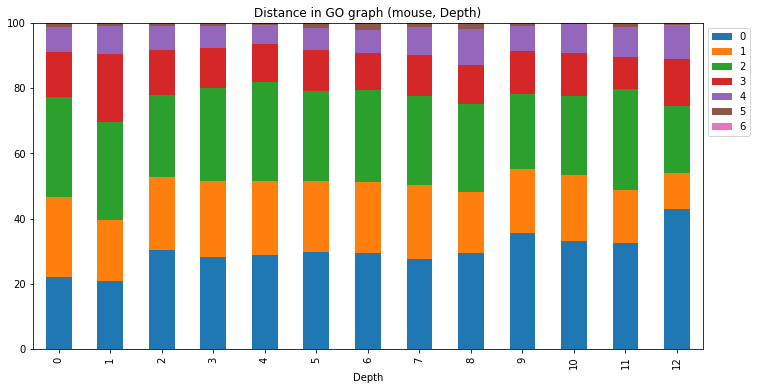

In [597]:
ax = mouse_result_df.drop(['Level', 'Genes_number', 'Edges_number'], axis=1
                    ).groupby('Depth', as_index=False).mean().plot.bar(
    x='Depth', 
    stacked=True, 
    title='Distance in GO graph (mouse, Depth)',
    figsize=(12,6))

ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_ylim(0, 100)

ax.figure.savefig('../data/08_GO_gene_subset/plots/mouse_depth.png')

# 2. GO gene clustering search
## 2.1. Load data

In [219]:
# Create dict level : list with genes lists for new_level
# if less than 10 genes -- do not add to dict
def get_all_terminal_names(tree, dict_for_results=defaultdict(list), level=0):
    if len(tree.get_leaf_names()) > 10:
        dict_for_results[level].append(tree.get_leaf_names())
        new_level = level + 1

        for cild in tree.get_children(): 
            get_all_terminal_names(cild, dict_for_results, new_level)

In [307]:
human_GRN = pd.read_csv('../data/08_GO_gene_subset/ages_lists/human_GRN_iddistances.csv')
human_GRN[['TF_ID', 'Target_ID']] = human_GRN[['TF_ID', 'Target_ID']].astype(str)

mouse_GRN = pd.read_csv('../data/08_GO_gene_subset/ages_lists/mouse_GRN_iddistances.csv')
mouse_GRN[['TF_ID', 'Target_ID']] = mouse_GRN[['TF_ID', 'Target_ID']].astype(str)

### 2.1.1. Human

In [290]:
human_tree_complete = Tree("../data/07_GO/dendrograms/humanBP_dend_complete.tree")
human_tree_ward = Tree("../data/07_GO/dendrograms/humanBP_dend_ward.tree")

human_tcompl_level = defaultdict(list)
human_tward_level = defaultdict(list)

get_all_terminal_names(human_tree_complete, human_tcompl_level)
get_all_terminal_names(human_tree_ward, human_tward_level)

### 2.1.1. Mouse

In [291]:
mouse_tree_complete = Tree("../data/07_GO/dendrograms/mouseBP_dend_complete.tree")
mouse_tree_ward = Tree("../data/07_GO/dendrograms/mouseBP_dend_ward.tree")

mouse_tcompl_level = defaultdict(list)
mouse_tward_level = defaultdict(list)

get_all_terminal_names(mouse_tree_complete, mouse_tcompl_level)
get_all_terminal_names(mouse_tree_ward, mouse_tward_level)

## 2.2. Create df with metric

### 2.2.1. Human

In [339]:
# human_tree_complete

# Create dataframe with distance metric
# select small GRN for GO term - сontains only GO terms with more than 10 genes.

human_resdf_tcompl = pd.DataFrame(columns = ['Level', 'SubLevel', 'Genes_number', 'Edges_number',
                                             0, 1, 2, 3, 4, 5, 6])
row_index = 0

for level in human_tcompl_level:
    # print(level, len(human_tcompl_level[level]))
    i = 0  # sublevel

    for gene_set in human_tcompl_level[level]:
        temp_GRN = select_subnet(gene_set, human_GRN)
        max_distance = human_GRN.age_length.max()
        distance_series = distance_calculation(temp_GRN, max_distance)

        if distance_series is not None:
            temp_row = [level, 
                        i,
                        len(gene_set), 
                        temp_GRN.shape[0]]
            temp_row.extend(distance_series.tolist())
            human_resdf_tcompl.loc[row_index] = temp_row

            i += 1
            row_index += 1
                
human_resdf_tcompl

,Level,SubLevel,Genes_number,Edges_number,0,1,2,3,4,5,6
0,0.0,0.0,2760.0,9161.0,20.936579,27.038533,28.031874,16.974129,5.861805,1.069752,0.087327
1,1.0,0.0,2712.0,9033.0,20.812576,27.155984,28.030555,17.004318,5.878446,1.029558,0.088564
2,2.0,0.0,1654.0,638.0,16.614420,32.915361,28.840125,14.420063,5.642633,1.253918,0.313480
3,2.0,1.0,1058.0,3201.0,23.086535,27.428928,27.147766,15.588878,5.685723,1.030928,0.031240
4,3.0,0.0,647.0,124.0,13.709677,36.290323,26.612903,18.548387,4.032258,0.806452,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
160,12.0,5.0,12.0,1.0,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
161,13.0,0.0,15.0,1.0,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
162,13.0,1.0,15.0,14.0,57.142857,21.428571,7.142857,14.285714,0.000000,0.000000,0.000000
163,13.0,2.0,17.0,2.0,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [340]:
# human_tree_ward

# Create dataframe with distance metric
# select small GRN for GO term - сontains only GO terms with more than 10 genes.

human_resdf_tward = pd.DataFrame(columns = ['Level', 'SubLevel', 'Genes_number', 'Edges_number',
                                             0, 1, 2, 3, 4, 5, 6])
row_index = 0

for level in human_tward_level:
    # print(level, len(human_tward_level[level]))
    i = 0  # sublevel

    for gene_set in human_tward_level[level]:
        temp_GRN = select_subnet(gene_set, human_GRN)
        max_distance = human_GRN.age_length.max()
        distance_series = distance_calculation(temp_GRN, max_distance)

        if distance_series is not None:
            temp_row = [level, i, len(gene_set), temp_GRN.shape[0]]            
            temp_row.extend(distance_series.tolist())

            human_resdf_tward.loc[row_index] = temp_row

            i += 1
            row_index += 1

human_resdf_tward

,Level,SubLevel,Genes_number,Edges_number,0,1,2,3,4,5,6
0,0.0,0.0,2760.0,9161.0,20.936579,27.038533,28.031874,16.974129,5.861805,1.069752,0.087327
1,1.0,0.0,1095.0,3387.0,23.619722,27.664600,26.719811,15.470918,5.432536,1.062888,0.029525
2,1.0,1.0,1665.0,630.0,16.507937,32.539683,28.571429,14.603175,6.031746,1.428571,0.317460
3,2.0,0.0,792.0,2432.0,21.463816,28.988487,25.534539,16.570724,6.250000,1.192434,0.000000
4,2.0,1.0,303.0,99.0,36.363636,16.161616,35.353535,9.090909,1.010101,2.020202,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
159,11.0,2.0,12.0,6.0,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
160,11.0,3.0,22.0,2.0,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000
161,11.0,4.0,11.0,1.0,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
162,12.0,0.0,11.0,3.0,66.666667,0.000000,33.333333,0.000000,0.000000,0.000000,0.000000


### 2.2.2. Mouse

In [341]:
# mouse_tree_complete
mouse_resdf_tcompl = pd.DataFrame(columns = ['Level', 'SubLevel', 'Genes_number', 'Edges_number',
                                             0, 1, 2, 3, 4, 5, 6])
row_index = 0

for level in mouse_tcompl_level:
    i = 0  # sublevel
    for gene_set in mouse_tcompl_level[level]:
        temp_GRN = select_subnet(gene_set, mouse_GRN)
        max_distance = mouse_GRN.age_length.max()
        distance_series = distance_calculation(temp_GRN, max_distance)

        if distance_series is not None:
            temp_row = [level, 
                        i,
                        len(gene_set), 
                        temp_GRN.shape[0]]
            temp_row.extend(distance_series.tolist())
            mouse_resdf_tcompl.loc[row_index] = temp_row

            i += 1
            row_index += 1
                
mouse_resdf_tcompl

,Level,SubLevel,Genes_number,Edges_number,0,1,2,3,4,5,6
0,0.0,0.0,2370.0,6857.0,22.079627,24.544261,30.756891,13.694035,7.641826,1.254193,0.029167
1,1.0,0.0,2355.0,6835.0,22.092173,24.550110,30.738844,13.694221,7.637162,1.258230,0.029261
2,2.0,0.0,2346.0,6812.0,22.108045,24.574281,30.725191,13.711098,7.589548,1.262478,0.029360
3,3.0,0.0,910.0,1839.0,33.387711,28.004350,30.179445,5.111474,2.990756,0.271887,0.054377
4,3.0,1.0,1436.0,1398.0,17.095851,20.743920,26.394850,19.957082,13.805436,1.931330,0.071531
...,...,...,...,...,...,...,...,...,...,...,...
155,14.0,1.0,22.0,20.0,20.000000,20.000000,30.000000,15.000000,15.000000,0.000000,0.000000
156,14.0,2.0,15.0,1.0,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
157,15.0,0.0,29.0,8.0,12.500000,12.500000,75.000000,0.000000,0.000000,0.000000,0.000000
158,15.0,1.0,12.0,16.0,25.000000,25.000000,31.250000,6.250000,12.500000,0.000000,0.000000


In [342]:
# mouse_tree_ward
mouse_resdf_tward = pd.DataFrame(columns = ['Level', 'SubLevel', 'Genes_number', 'Edges_number',
                                             0, 1, 2, 3, 4, 5, 6])
row_index = 0

for level in mouse_tward_level:
    # print(level, len(human_tward_level[level]))
    i = 0  # sublevel

    for gene_set in mouse_tward_level[level]:
        temp_GRN = select_subnet(gene_set, mouse_GRN)
        max_distance = mouse_GRN.age_length.max()
        distance_series = distance_calculation(temp_GRN, max_distance)

        if distance_series is not None:
            temp_row = [level, i, len(gene_set), temp_GRN.shape[0]]            
            temp_row.extend(distance_series.tolist())

            mouse_resdf_tward.loc[row_index] = temp_row

            i += 1
            row_index += 1

mouse_resdf_tward

,Level,SubLevel,Genes_number,Edges_number,0,1,2,3,4,5,6
0,0.0,0.0,2370.0,6857.0,22.079627,24.544261,30.756891,13.694035,7.641826,1.254193,0.029167
1,1.0,0.0,1023.0,49.0,26.530612,14.285714,16.326531,16.326531,18.367347,6.122449,2.040816
2,1.0,1.0,1347.0,4317.0,25.943943,25.851286,30.646282,10.099606,6.601807,0.833912,0.023164
3,2.0,0.0,712.0,36.0,25.000000,19.444444,13.888889,16.666667,19.444444,5.555556,0.000000
4,2.0,1.0,779.0,2412.0,24.792703,22.553897,32.172471,11.152570,8.043118,1.285240,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
141,11.0,1.0,20.0,6.0,50.000000,16.666667,16.666667,0.000000,16.666667,0.000000,0.000000
142,11.0,2.0,12.0,3.0,33.333333,0.000000,66.666667,0.000000,0.000000,0.000000,0.000000
143,11.0,3.0,16.0,3.0,33.333333,33.333333,33.333333,0.000000,0.000000,0.000000,0.000000
144,11.0,4.0,12.0,1.0,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## 2.3.  Plot results
### 2.3.1. Human

In [329]:
human_resdf_tcompl.drop(['SubLevel'], axis=1).groupby('Level').mean()

,Genes_number,Edges_number,0,1,2,3,4,5,6
Level,,,,,,,,,
0.0,2760.000000,9161.000000,20.936579,27.038533,28.031874,16.974129,5.861805,1.069752,0.087327
1.0,2712.000000,9033.000000,20.812576,27.155984,28.030555,17.004318,5.878446,1.029558,0.088564
2.0,1356.000000,1919.500000,19.850478,30.172144,27.993946,15.004471,5.664178,1.142423,0.172360
3.0,894.000000,1158.000000,20.004162,30.760747,26.886953,15.543590,5.561912,1.076243,0.166392
4.0,535.800000,451.600000,23.111429,29.761439,26.295426,14.378432,5.949615,0.503658,0.000000
5.0,333.250000,169.750000,23.081222,33.503460,23.663404,14.306317,5.162981,0.282617,0.000000
6.0,220.454545,92.818182,30.345331,28.243686,24.584111,13.461295,3.179104,0.186473,0.000000
7.0,137.882353,40.411765,27.500964,35.116483,25.025109,9.088646,3.143307,0.125491,0.000000
8.0,76.884615,13.884615,35.614123,27.909716,26.470653,7.699581,2.305927,0.000000,0.000000


<Figure size 432x288 with 0 Axes>

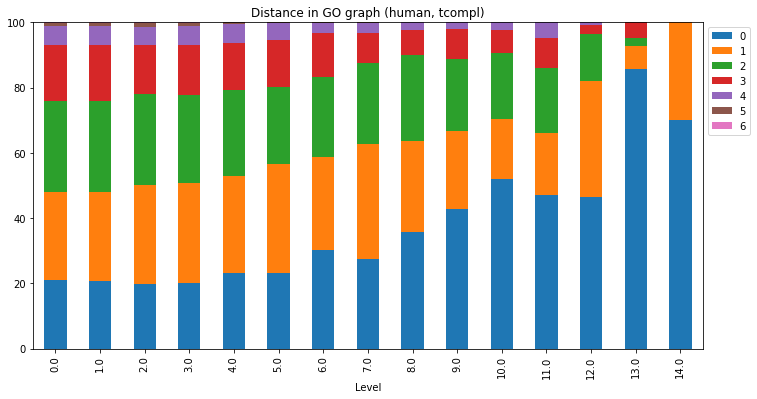

In [335]:
fig = plt.figure()

ax = human_resdf_tcompl.drop(['SubLevel', 'Genes_number', 'Edges_number'], axis=1
                        ).groupby('Level', as_index=False).mean().plot.bar(
    x='Level', 
    stacked=True, 
    title='Distance in GO graph (human, tcompl)',
    figsize=(12,6))

ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_ylim(0, 100)

ax.figure.savefig('../data/08_GO_gene_subset/plots/human_tcompl_level.png')

In [330]:
human_resdf_tward.drop(['SubLevel'], axis=1).groupby('Level').mean()

,Genes_number,Edges_number,0,1,2,3,4,5,6
Level,,,,,,,,,
0.0,2760.000000,9161.000000,20.936579,27.038533,28.031874,16.974129,5.861805,1.069752,0.087327
1.0,1380.000000,2008.500000,20.063829,30.102141,27.645620,15.037046,5.732141,1.245729,0.173492
2.0,690.000000,714.250000,23.790448,28.590373,28.958476,12.966177,4.483204,1.109282,0.102041
3.0,388.857143,204.000000,22.927960,28.517850,29.050664,12.784016,6.271912,0.447598,0.000000
4.0,208.153846,67.461538,23.797054,28.904382,30.501503,10.800394,5.645894,0.350773,0.000000
5.0,114.954545,26.454545,28.228626,30.206403,24.880324,11.732223,4.895869,0.056556,0.000000
6.0,73.250000,12.642857,32.799984,21.002243,28.622586,11.544725,5.941031,0.089431,0.000000
7.0,48.428571,6.750000,31.799954,28.900851,26.780778,5.736310,3.174603,3.607504,0.000000
8.0,33.652174,5.913043,43.346148,29.898930,17.086289,6.327359,3.281715,0.059559,0.000000


<Figure size 432x288 with 0 Axes>

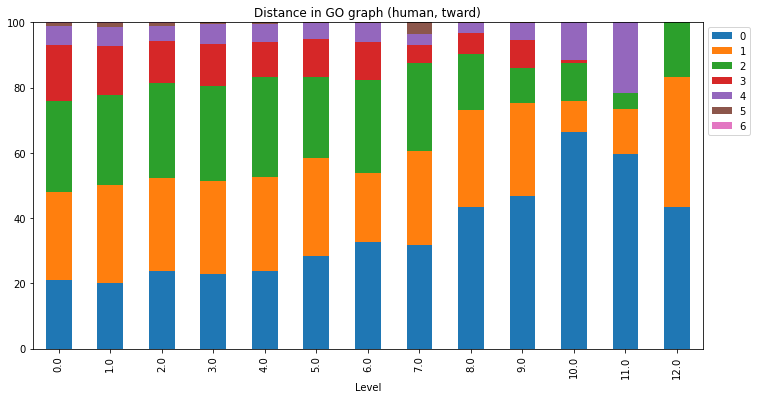

In [336]:
fig = plt.figure()

ax = human_resdf_tward.drop(['SubLevel', 'Genes_number', 'Edges_number'], axis=1
                        ).groupby('Level', as_index=False).mean().plot.bar(
    x='Level', 
    stacked=True, 
    title='Distance in GO graph (human, tward)',
    figsize=(12,6))

ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_ylim(0, 100)

ax.figure.savefig('../data/08_GO_gene_subset/plots/human_tward_level.png')

### 2.3.2. Human

In [331]:
mouse_resdf_tcompl.drop(['SubLevel'], axis=1).groupby('Level').mean()

,Genes_number,Edges_number,0,1,2,3,4,5,6
Level,,,,,,,,,
0.0,2370.000000,6857.000000,22.079627,24.544261,30.756891,13.694035,7.641826,1.254193,0.029167
1.0,2355.000000,6835.000000,22.092173,24.550110,30.738844,13.694221,7.637162,1.258230,0.029261
2.0,2346.000000,6812.000000,22.108045,24.574281,30.725191,13.711098,7.589548,1.262478,0.029360
3.0,1173.000000,1618.500000,25.241781,24.374135,28.287148,12.534278,8.398096,1.101609,0.062954
4.0,586.500000,627.250000,23.796133,23.767167,26.599507,12.527814,10.813596,1.408826,1.086957
5.0,341.166667,256.500000,28.308133,22.974854,22.343562,8.911660,16.204659,1.257133,0.000000
6.0,203.700000,109.900000,25.761085,25.341651,20.670771,6.789628,11.304311,10.132554,0.000000
7.0,120.000000,60.312500,38.096983,20.204329,19.255227,4.868269,11.122646,6.452546,0.000000
8.0,79.000000,32.272727,41.972721,21.982644,20.448551,4.665958,6.336825,4.593301,0.000000


<Figure size 432x288 with 0 Axes>

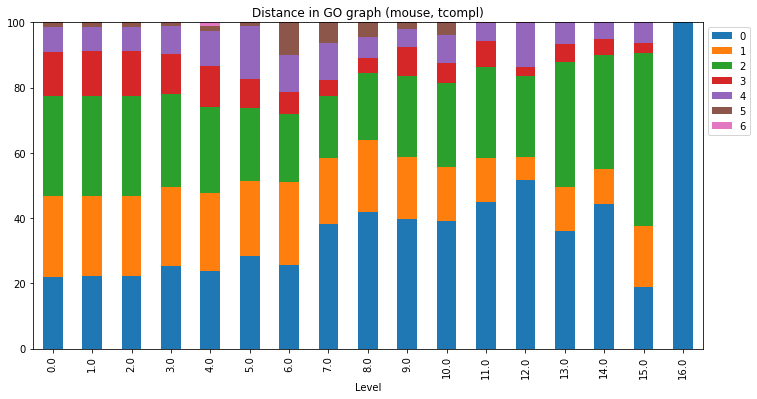

In [337]:
fig = plt.figure()

ax = mouse_resdf_tcompl.drop(['SubLevel', 'Genes_number', 'Edges_number'], axis=1
                        ).groupby('Level', as_index=False).mean().plot.bar(
    x='Level', 
    stacked=True, 
    title='Distance in GO graph (mouse, tcompl)',
    figsize=(12,6))

ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_ylim(0, 100)

ax.figure.savefig('../data/08_GO_gene_subset/plots/mouse_tcompl_level.png')

In [332]:
mouse_resdf_tward.drop(['SubLevel'], axis=1).groupby('Level').mean()

,Genes_number,Edges_number,0,1,2,3,4,5,6
Level,,,,,,,,,
0.0,2370.000000,6857.000000,22.079627,24.544261,30.756891,13.694035,7.641826,1.254193,0.029167
1.0,1185.000000,2183.000000,26.237277,20.068500,23.486406,13.213068,12.484577,3.478181,1.031990
2.0,686.333333,938.000000,28.528351,24.928409,23.732657,10.821349,9.708969,2.280265,0.000000
3.0,437.000000,388.000000,28.373287,26.048985,21.524007,13.415023,8.692642,1.946055,0.000000
4.0,218.500000,126.875000,22.757362,25.603761,21.483976,7.563975,16.617523,5.973403,0.000000
5.0,134.000000,62.916667,26.016063,21.314523,17.502142,10.946222,14.690154,9.530896,0.000000
6.0,78.000000,26.421053,42.413757,18.107983,17.098832,6.610181,8.812538,6.956710,0.000000
7.0,44.777778,12.370370,45.276691,15.118540,19.668890,8.269934,6.608200,5.057746,0.000000
8.0,27.633333,6.566667,46.443354,17.714646,20.345897,8.461503,5.923488,1.111111,0.000000


<Figure size 432x288 with 0 Axes>

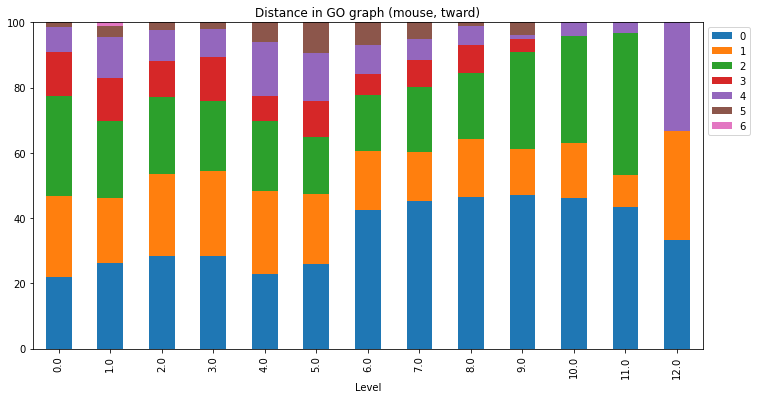

In [338]:
fig = plt.figure()

ax = mouse_resdf_tward.drop(['SubLevel', 'Genes_number', 'Edges_number'], axis=1
                        ).groupby('Level', as_index=False).mean().plot.bar(
    x='Level', 
    stacked=True, 
    title='Distance in GO graph (mouse, tward)',
    figsize=(12,6))

ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_ylim(0, 100)

ax.figure.savefig('../data/08_GO_gene_subset/plots/mouse_tward_level.png')